In [1]:
########################################
## import packages
########################################
import os
import re
import csv
import codecs
from collections import defaultdict
import numpy as np
import pandas as pd
#from imp import reload

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation

from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Convolution1D, GlobalMaxPooling1D

import sys

In [2]:
########################################
## set directories and parameters
########################################
BASE_DIR = '../input/'
EMBEDDING_FILE = 'Sources\\GoogleNews-vectors-negative300.bin.gz'
TRAIN_DATA_FILE = 'Sources\\train and test.csv\\pTtrain.csv'
TEST_DATA_FILE = 'Sources\\train and test.csv\\pTtest.csv'
MAX_SEQUENCE_LENGTH = 30
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.1

num_lstm = np.random.randint(175, 275)
num_dense = np.random.randint(100, 150)
rate_drop_lstm = 0.15 + np.random.rand() * 0.25
rate_drop_dense = 0.15 + np.random.rand() * 0.25

print("rate_drop_lstm", rate_drop_lstm )
print("rate_drop_dense", rate_drop_dense)

act = 'relu'
re_weight = True # whether to re-weight classes to fit the 17.5% share in test set

STAMP = 'lstm_%d_%d_%.2f_%.2f'%(num_lstm, num_dense, rate_drop_lstm, \
                                rate_drop_dense)

rate_drop_lstm 0.2950911431673208
rate_drop_dense 0.19936023594971083


In [3]:
########################################
## index word vectors
########################################
print('Indexing word vectors')

word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, \
                                             binary=True)
print('Found %s word vectors of word2vec' % len(word2vec.vocab))

Indexing word vectors
Found 3000000 word vectors of word2vec


In [4]:
########################################
## process texts in datasets
########################################
print('Processing text dataset')

# The function "text_to_wordlist" is from
# https://www.kaggle.com/currie32/quora-question-pairs/the-importance-of-cleaning-text
def text_to_wordlist(text, remove_stopwords=False, stem_words=False):
    # Clean the text, with the option to remove stopwords and to stem words.

    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]

    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)

    # Return a list of words
    return(text)

def q1_q2_intersect(row):
    return(len(set(q_dict[row['question1']]).intersection(set(q_dict[row['question2']]))))

def try_apply_dict(x,dict_to_apply):
    try:
        return dict_to_apply[x]
    except KeyError:
        return 0

Processing text dataset


In [5]:
texts_1 = []
texts_2 = []
labels = []
with codecs.open(TRAIN_DATA_FILE, encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=',')
    header = next(reader)
    for values in reader:
        texts_1.append(text_to_wordlist(values[3]))
        texts_2.append(text_to_wordlist(values[4]))
        labels.append(int(values[5]))
print('Found %s texts in pTtrain.csv' % len(texts_1))
print("Value of text_1 is ",texts_1)
print("Value of text_2 is ",texts_2)

train_orig =  pd.read_csv('Sources\\train and test.csv\\pTtrain.csv', header=0)
print("trainOrignal")
print(train_orig)

test_texts_1 = []
test_texts_2 = []
test_ids = []
with codecs.open(TEST_DATA_FILE, encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=',')
    header = next(reader)
    for values in reader:
        test_texts_1.append(text_to_wordlist(values[1]))
        test_texts_2.append(text_to_wordlist(values[2]))
        test_ids.append(values[0])
print('Found %s texts in pTtest.csv' % len(test_texts_1))
print("test_texts_1 is :",test_texts_1)
print("test_texts_2 is :",test_texts_2)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



trainOrignal
            id    qid1    qid2  \
0            0       1       2   
1            1       3       4   
2            2       5       6   
3            3       7       8   
4            4       9      10   
...        ...     ...     ...   
208425  208425  416851  416852   
208426  208426  416853  416854   
208427  208427  416855  416856   
208428  208428  416857  416858   
208429  208429  416859  416860   

                                                question1  \
0                       use config property file variable   
1       way use list string parameter regular expressi...   
2                                  overlap two date range   
3                             stringlength 2 split string   
4                java 8 stream join return multiple value   
...                                                   ...   
208425                                 xssf poi cell date   
208426                  use config property file variable   
208427                       

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [6]:
test_orig =  pd.read_csv('Sources\\train and test.csv\\pTtest.csv', header=0)
print("testOrignal", test_orig)

ques = pd.concat([train_orig[['question1', 'question2']], \
                  test_orig[['question1', 'question2']]], axis=0).reset_index(drop='index')

print("Value of ques is:", ques)

q_dict = defaultdict(set)
for i in range(ques.shape[0]):
    q_dict[ques.question1[i]].add(ques.question2[i])
    q_dict[ques.question2[i]].add(ques.question1[i])
print("ques Dictionary")
print(q_dict)

testOrignal        test_id                                          question1  \
0            0  way use list string parameter regular expressi...   
1            1                             overlap two date range   
2            2                        stringlength 0 split string   
3            3           java 8 stream join return multiple value   
4            4  pointcut match method annotate directly inheri...   
...        ...                                                ...   
208424  208419                                 xssf poi cell date   
208425  208420                  use config property file variable   
208426  208421                             chain task use generic   
208427  208422                             rebuild quickfix j ant   
208428  208423                       arrange array order odd even   

                                            question2  
0                          java regex capture group x  
1                           unable get total de

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [7]:
train_feat = train_orig.apply(q1_q2_intersect, axis=1, raw=False)
test_feat = test_orig.apply(q1_q2_intersect, axis=1, raw=False)
print("train feat:", train_feat)
print("test feat:", test_feat)

train feat: 0         1
1         7
2         0
3         0
4         0
         ..
208425    0
208426    1
208427    0
208428    0
208429    0
Length: 208430, dtype: int64
test feat: 0         7
1         0
2         0
3         0
4         8
         ..
208424    0
208425    1
208426    0
208427    0
208428    0
Length: 208429, dtype: int64


In [8]:
######################################################################
df1 = train_orig[['question1']].copy()
df2 = train_orig[['question2']].copy()
df1_test = test_orig[['question1']].copy()
df2_test = test_orig[['question2']].copy()

print("df1 value is:", df1)
print("df2 value is:", df2)
print("df1_test value is:", df1_test)
print("df2_test value is:", df2_test)
# print("now stop:")

df2.rename(columns = {'question2':'question1'},inplace=True)
df2_test.rename(columns = {'question2':'question1'},inplace=True)
print("Renamining df2:", df2)
print("Renamining df2_test:", df2_test)

train_questions = df1.append(df2)
train_questions = train_questions.append(df1_test)
train_questions = train_questions.append(df2_test)
# train_questions.drop_duplicates(subset = ['qid1'],inplace=True)
print("Train questions are:", train_questions)
train_questions.drop_duplicates(subset = ['question1'],inplace=True)
print("after duplicate removal:", train_questions)

df1 value is:                                                 question1
0                       use config property file variable
1       way use list string parameter regular expressi...
2                                  overlap two date range
3                             stringlength 2 split string
4                java 8 stream join return multiple value
...                                                   ...
208425                                 xssf poi cell date
208426                  use config property file variable
208427                             chain task use generic
208428                             rebuild quickfix j ant
208429                       arrange array order odd even

[208430 rows x 1 columns]
df2 value is:                                             question2
0       use property property file property file java
1                          java regex capture group x
2                           unable get total decrease
3              convert dot separa

In [9]:
# IN MORNING
train_questions.reset_index(inplace=True,drop=True)
print("Train Questions after resetting", train_questions)
questions_dict = pd.Series(train_questions.index.values,index=train_questions.question1.values).to_dict()
print("Question Dictionary is", questions_dict) #Stores all questions (What is the step by step guide to invest in share market in india?': 0, 'What is the story of Kohinoor (Koh-i-Noor) Diamond?': 1)
train_cp = train_orig.copy()
print("Train_CP")
print(train_cp)
test_cp = test_orig.copy()
print("Test_CP")
print(test_cp)

train_cp.drop(['qid1','qid2'],axis=1,inplace=True)

test_cp['is_duplicate'] = -1
test_cp.rename(columns={'test_id':'id'},inplace=True)
comb = pd.concat([train_cp,test_cp])
print("Comb is:", comb)

comb['q1_hash'] = comb['question1'].map(questions_dict)
comb['q2_hash'] = comb['question2'].map(questions_dict)
print("Comb[q1 hash] is:", comb['q1_hash'])
print("Comb is[q2 hash]:", comb['q2_hash'])

q1_vc = comb.q1_hash.value_counts().to_dict()
q2_vc = comb.q2_hash.value_counts().to_dict()

print("q1_vc is:", q1_vc)
print("q2_vc is:", q2_vc)

comb['q1_freq'] = comb['q1_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))
comb['q2_freq'] = comb['q2_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))

print("q1_freq is", comb['q1_freq'])

train_comb = comb[comb['is_duplicate'] >= 0][['id','q1_hash','q2_hash','q1_freq','q2_freq','is_duplicate']]
test_comb = comb[comb['is_duplicate'] < 0][['id','q1_hash','q2_hash','q1_freq','q2_freq']]
print("train_comb is\n", train_comb)
print("test_comb is\n", test_comb)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Comb[q1 hash] is: 0              0
1              1
2              2
3              3
4              4
           ...  
208424     64897
208425         0
208426    100321
208427    100322
208428      5533
Name: q1_hash, Length: 416859, dtype: int64
Comb is[q2 hash]: 0         100323
1          24983
2          70322
3         100324
4         100325
           ...  
208424      5286
208425    100323
208426    111373
208427    125522
208428     12826
Name: q2_hash, Length: 416859, dtype: int64
q1_vc is: {779: 104, 9087: 88, 2124: 86, 2528: 78, 1507: 78, 382: 74, 1720: 74, 8598: 68, 3456: 68, 6011: 66, 4389: 66, 1533: 66, 10626: 64, 2789: 64, 17929: 64, 5562: 64, 14141: 62, 374: 62, 13365: 62, 545: 62, 1515: 62, 10498: 60, 7013: 60, 11082: 60, 3619: 60, 89: 58, 146: 58, 8274: 58, 3465: 56, 749: 56, 11041: 56, 1229: 56, 3387: 56, 5292: 56, 3603: 54, 13961: 54, 2538: 54, 3399: 52, 21606: 52, 1385: 52, 15275: 52, 6416: 52, 6025: 50, 51: 50, 18547: 50, 4957: 50, 1604: 50, 11078: 50, 12315: 5

q1_freq is 0         19
1         34
2          8
3          1
4          6
          ..
208424     8
208425    19
208426     4
208427     2
208428     6
Name: q1_freq, Length: 416859, dtype: int64
train_comb is
             id  q1_hash  q2_hash  q1_freq  q2_freq  is_duplicate
0            0        0   100323       19        5             0
1            1        1    24983       34       30             0
2            2        2    70322        8        4             0
3            3        3   100324        1        2             1
4            4        4   100325        6        2             0
...        ...      ...      ...      ...      ...           ...
208425  208425    64897     5286        8        8             0
208426  208426        0   100323       19        5             0
208427  208427   100321   111373        4        4             0
208428  208428   100322   125522        2        4             0
208429  208429     5533    12826        6        4             0

[20843

In [10]:
train_q1_freq = train_comb['q1_freq']
train_q2_freq = train_comb['q2_freq']
test_q1_freq = test_comb['q1_freq']
test_q2_freq = test_comb['q2_freq']

print("train_q1_freq", train_q1_freq)
print("train_q2_freq",train_q2_freq)
print("test_q1_freq",test_q1_freq)
print("test_q1_freq",test_q2_freq)
#####################################################################

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts_1 + texts_2 + test_texts_1 + test_texts_2)
print("value of tokenizer is:")
print(tokenizer)

sequences_1 = tokenizer.texts_to_sequences(texts_1)
print("Sequence 1 is:")
print(sequences_1)
sequences_2 = tokenizer.texts_to_sequences(texts_2)
print("Sequence 2 is:")
print(sequences_2)
test_sequences_1 = tokenizer.texts_to_sequences(test_texts_1)
test_sequences_2 = tokenizer.texts_to_sequences(test_texts_2)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))
print("word index is", word_index)

data_1 = pad_sequences(sequences_1, maxlen=MAX_SEQUENCE_LENGTH)
data_2 = pad_sequences(sequences_2, maxlen=MAX_SEQUENCE_LENGTH)
labels = np.array(labels)
print("data 1 is", data_1)
print("data 2 is", data_2)
print('Shape of data tensor:', data_1.shape)
print('Shape of label tensor:', labels.shape)
print("Labels are", labels)

test_data_1 = pad_sequences(test_sequences_1, maxlen=MAX_SEQUENCE_LENGTH)
test_data_2 = pad_sequences(test_sequences_2, maxlen=MAX_SEQUENCE_LENGTH)
test_ids = np.array(test_ids)
print('Shape of test data tensor:', test_data_1.shape)
print('data of test data tensor:', test_data_1)
print('Shape of label tensor:', test_ids)

train_q1_freq 0         19
1         34
2          8
3          1
4          6
          ..
208425     8
208426    19
208427     4
208428     2
208429     6
Name: q1_freq, Length: 208430, dtype: int64
train_q2_freq 0          5
1         30
2          4
3          2
4          2
          ..
208425     8
208426     5
208427     4
208428     4
208429     4
Name: q2_freq, Length: 208430, dtype: int64
test_q1_freq 0         34
1          8
2          5
3          6
4         34
          ..
208424     8
208425    19
208426     4
208427     2
208428     6
Name: q1_freq, Length: 208429, dtype: int64
test_q1_freq 0         30
1          4
2          2
3          2
4         28
          ..
208424     8
208425     5
208426     4
208427     4
208428     4
Name: q2_freq, Length: 208429, dtype: int64
value of tokenizer is:


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Found 35138 unique tokens
word index is {'java': 1, 'use': 2, 'file': 3, 'class': 4, 'get': 5, 'string': 6, 'error': 7, 'method': 8, 'spring': 9, 'object': 10, 'android': 11, 'value': 12, 'exception': 13, 'array': 14, 'work': 15, 'create': 16, 'find': 17, 'hibernate': 18, 'data': 19, 'list': 20, 'code': 21, 'eclipse': 22, 'null': 23, 'run': 24, 'application': 25, 'type': 26, 'call': 27, 'return': 28, 'read': 29, 'add': 30, 'thread': 31, 'set': 32, 'convert': 33, 'server': 34, 'variable': 35, 'multiple': 36, 'json': 37, 'number': 38, 'program': 39, 'nullpointerexception': 40, 'map': 41, 'name': 42, 'database': 43, 'make': 44, 'change': 45, 'text': 46, 'loop': 47, 'test': 48, 'access': 49, 'project': 50, 'jar': 51, 'one': 52, 'arraylist': 53, 'xml': 54, 'way': 55, 'without': 56, 'maven': 57, 'app': 58, 'parameter': 59, 'image': 60, 'reference': 61, 'two': 62, 'time': 63, 'request': 64, 'jpa': 65, 'pas': 66, 'web': 67, 'element': 68, 'date': 69, 'check': 70, 'different': 71, 'try': 72, 'g

data 1 is [[    0     0     0 ...    83     3    35]
 [    0     0     0 ...  1157   102     6]
 [    0     0     0 ...    62    69   294]
 ...
 [    0     0     0 ...   321     2   110]
 [    0     0     0 ... 14309   902   400]
 [    0     0     0 ...   214  1326   362]]
data 2 is [[    0     0     0 ...    83     3     1]
 [    0     0     0 ...   572   388   308]
 [    0     0     0 ...     5  1076  2579]
 ...
 [    0     0     0 ...   387   103   459]
 [    0     0     0 ...  2753 26702 12982]
 [    0     0     0 ...     6   443   336]]
Shape of data tensor: (208430, 30)
Shape of label tensor: (208430,)
Labels are [0 0 0 ... 0 0 0]
Shape of test data tensor: (208429, 30)
data of test data tensor: [[    0     0     0 ...  1157   102     6]
 [    0     0     0 ...    62    69   294]
 [    0     0     0 ...    87   208     6]
 ...
 [    0     0     0 ...   321     2   110]
 [    0     0     0 ... 14309   902   400]
 [    0     0     0 ...   214  1326   362]]
Shape of label tensor: ['

In [11]:
########################################
## prepare embeddings
########################################
print('Preparing embedding matrix')

nb_words = min(MAX_NB_WORDS, len(word_index))+1

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
        # print("Word:",i, word, word2vec.word_vec(word))
# print("Embedding matrice is:")
print(embedding_matrix)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Preparing embedding matrix
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.13574219 -0.19042969 -0.37304688 ...  0.01867676  0.06542969
   0.29882812]
 [ 0.11279297 -0.13085938  0.06689453 ... -0.17285156 -0.07910156
   0.05786133]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
Null word embeddings: 26358


In [12]:
########################################
## sample train/validation data
########################################
#np.random.seed(1234)
perm = np.random.permutation(len(data_1))
print("perm is:", perm)
idx_train = perm[:int(len(data_1)*(1-VALIDATION_SPLIT))]
print("idx_train are:", idx_train)
idx_val = perm[int(len(data_1)*(1-VALIDATION_SPLIT)):]
print("idx_val are:", idx_val)

# myList = []
# l = []
# for i in range(2, 11, 2):
#     myList.append(i)
# myList = []
# idx_train = (myList[0:10])
# print(idx_train)
# idx_val = myList[10:]
# print(idx_val)
# # idx_train = [0:11]

# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(idx_train, idx_val, test_size=0.33)

data_1_train = np.vstack((data_1[idx_train], data_2[idx_train]))
data_2_train = np.vstack((data_2[idx_train], data_1[idx_train]))
labels_train = np.concatenate((labels[idx_train], labels[idx_train]))
feat_train   = np.concatenate((train_feat[idx_train], train_feat[idx_train]))
q1_train     = np.concatenate((train_q1_freq[idx_train], train_q2_freq[idx_train]))
q2_train     = np.concatenate((train_q2_freq[idx_train], train_q1_freq[idx_train]))

print("data_1_train", data_1_train)
print("data_2_train", data_2_train)
print("labels_train", labels_train)
print("feat_train", feat_train)
print("q1_train", q1_train)
print("q2_train", q2_train)



data_1_val = np.vstack((data_1[idx_val], data_2[idx_val]))
data_2_val = np.vstack((data_2[idx_val], data_1[idx_val]))
labels_val = np.concatenate((labels[idx_val], labels[idx_val]))
feat_val   = np.concatenate((train_feat[idx_val], train_feat[idx_val]))
q1_val     = np.concatenate((train_q1_freq[idx_val], train_q2_freq[idx_val]))
q2_val     = np.concatenate((train_q2_freq[idx_val], train_q1_freq[idx_val]))


print("q1_val", q1_val)
print("q2_val", q2_val)

weight_val = np.ones(len(labels_val))
if re_weight:
    weight_val *= 0.472001959
    weight_val[labels_val==0] = 1.309028344

perm is: [ 85321  76068 129883 ... 151498   2375   7825]
idx_train are: [ 85321  76068 129883 ...   6798 194306  13362]
idx_val are: [207269  17837  38553 ... 151498   2375   7825]
data_1_train [[    0     0     0 ...    14    71     4]
 [    0     0     0 ...  4087  1436   551]
 [    0     0     0 ... 19402    15  1293]
 ...
 [    0     0     0 ... 17199 17200   282]
 [    0     0     0 ...    10   913   432]
 [    0     0     0 ...  2448   863   282]]
data_2_train [[    0     0     0 ...   550   488 13835]
 [    0     0     0 ...   171   685     1]
 [    0     0     0 ...     6  1939     1]
 ...
 [    0     0     0 ...   209    17   109]
 [    0     0     0 ...   148   285  3422]
 [    0     0     0 ...   863    74    15]]
labels_train [0 1 1 ... 0 0 1]
feat_train [0 3 2 ... 0 0 4]
q1_train [ 2  8  6 ...  6  4 16]
q2_train [10 16  6 ...  8  4 14]
q1_val [22 18  6 ...  6  8 16]
q2_val [22 20  2 ... 20  6 10]


In [13]:
########################################
## define the model structure
########################################
embedding_layer = Embedding(nb_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
#lstm_layer = LSTM(num_lstm, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm)

sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
# print("sequence1input is", sequence_1_input)
embedded_sequences_1 = embedding_layer(sequence_1_input)
# print("embedded_sequences_1", embedded_sequences_1)
#x1 = lstm_layer(embedded_sequences_1)

#print("Value of x1 is:", x1)

sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
#y1 = lstm_layer(embedded_sequences_2)
print("Value of y1 is:", y1)

Value of x1 is: Tensor("lstm/strided_slice_3:0", shape=(None, 182), dtype=float32)
Value of y1 is: Tensor("lstm/strided_slice_7:0", shape=(None, 182), dtype=float32)


In [14]:
###################################
model3 = Embedding(len(word_index) + 1,
                   300,
                   weights=[embedding_matrix],
                   input_length=40,
                   trainable=False)(sequence_1_input)

model3 = Convolution1D(filters=64, padding='valid',kernel_size=3,activation='relu',strides=1)(model3)
model3 = Dropout(0.3)(model3)

model3 = Convolution1D(filters=64,
                       
                       padding='valid',
                       kernel_size=3,activation='relu',
                       strides=1)(model3)

model3 = GlobalMaxPooling1D()(model3)
model3 = Dropout(0.3)(model3)

model3 = Dense(300)(model3)
model3 = Dropout(0.3)(model3)
model3 = BatchNormalization()(model3)
print("Model 3 is:", model3)

Model 3 is: Tensor("batch_normalization/batchnorm/add_1:0", shape=(None, 300), dtype=float32)


In [15]:
from keras.models import Sequential
#####Model 4
model4 = Sequential()
model4 = Embedding(len(word_index) + 1,
                   300,
                   weights=[embedding_matrix],
                   input_length=40,
                   trainable=False)(sequence_2_input)

model4 = Convolution1D(filters=64,
                       
                       
                       kernel_size=3,
                       activation='relu',
                      )(model4)
model4 = Dropout(0.3)(model4)

model4 = Convolution1D(filters=64,
                       
                       
                       
                       kernel_size=3,
                       activation='relu',
                       )(model4)

model4 = GlobalMaxPooling1D()(model4)
model4 = Dropout(0.3)(model4)

model4 = Dense(300)(model4)
model4 = Dropout(0.3)(model4)
model4 = BatchNormalization()(model4)
print("Model 4 is:", model4)

Model 4 is: Tensor("batch_normalization_1/batchnorm/add_1:0", shape=(None, 300), dtype=float32)


In [20]:
###################################



z1 = Input(shape=(1,), dtype='float32')

print("Value of z1 is:", z1)
a1 = Input(shape=(1,), dtype='float32')
b1 = Input(shape=(1,), dtype='float32')
print("Value of a1 is:", a1)
print("Value of b1 is:", b1)


# print("x is", x)
# print("x1 is:", x1)
# print("y1 is:", y1)
# print("z1 is:", z1)
# print("a1 is:", a1)
# print("b1 is:", b1)

merged = concatenate([model3, model4, z1, a1, b1])

# print("Models concatenated now:")
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

merged = Dense(num_dense, activation=act)(merged)
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

preds = Dense(1, activation='sigmoid')(merged)
# print("Making Predictions now")
########################################
## add class weight
#######################################
if re_weight:
    class_weight = {0: 1.309028344, 1: 0.472001959}
else:
    class_weight = None

Value of z1 is: Tensor("input_6:0", shape=(None, 1), dtype=float32)
Value of a1 is: Tensor("input_7:0", shape=(None, 1), dtype=float32)
Value of b1 is: Tensor("input_8:0", shape=(None, 1), dtype=float32)


In [17]:
########################################
## train the model
########################################
############################
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [23]:
# Creating the Confusion Matrix


#############################

# print("Now entering in Model")
model = Model(inputs=[sequence_1_input, sequence_2_input, z1, a1, b1], 
              outputs=preds)
# print("Now Leaving in Model")
# print("Now entering in Model Compilation")
model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=['acc', f1_m, precision_m, recall_m])
# print("Now Leaving in Model Compile")
#model.summary()
print(STAMP)


# early_stopping =EarlyStopping(monitor='val_loss', patience=10)
bst_model_path = STAMP + '.h5'
# print("Now entering in Model Checkpoints")
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)
# print("Now Leaving in Model Checkpoints")

# print("Now entering in Model Fitting")
hist = model.fit([data_1_train, data_2_train, feat_train, q1_train, q2_train], labels_train, \
                 validation_data=([data_1_val, data_2_val, feat_val, q1_val, q2_val], labels_val), \
                 epochs=25, batch_size=2048, shuffle=True, \
                 callbacks=[model_checkpoint])
# print("Now Leaving in Model Fitting")

lstm_182_128_0.30_0.20
Epoch 1/25
184/184 [==============================] - 64s 346ms/step - loss: 0.6498 - acc: 0.6152 - f1_m: 0.5819 - precision_m: 0.6404 - recall_m: 0.5350 - val_loss: 0.6366 - val_acc: 0.6304 - val_f1_m: 0.4875 - val_precision_m: 0.8094 - val_recall_m: 0.3490
Epoch 2/25
184/184 [==============================] - 74s 405ms/step - loss: 0.6098 - acc: 0.6528 - f1_m: 0.6035 - precision_m: 0.7031 - recall_m: 0.5289 - val_loss: 0.5993 - val_acc: 0.6618 - val_f1_m: 0.5819 - val_precision_m: 0.7737 - val_recall_m: 0.4665
Epoch 3/25
184/184 [==============================] - 63s 343ms/step - loss: 0.5925 - acc: 0.6677 - f1_m: 0.6234 - precision_m: 0.7187 - recall_m: 0.5507 - val_loss: 0.5789 - val_acc: 0.6812 - val_f1_m: 0.6560 - val_precision_m: 0.7194 - val_recall_m: 0.6032
Epoch 4/25
184/184 [==============================] - 61s 334ms/step - loss: 0.5800 - acc: 0.6787 - f1_m: 0.6391 - precision_m: 0.7286 - recall_m: 0.5694 - val_loss: 0.5675 - val_acc: 0.6857 - val_f1_

Best Log_loss Value is:  0.4960484504699707
Best Val_acc Value is:  0.7401285767555237
Best F1 Score is:  0.7334631681442261
Best Precision is:  0.8094052672386169
Best Recall is:  0.732311487197876


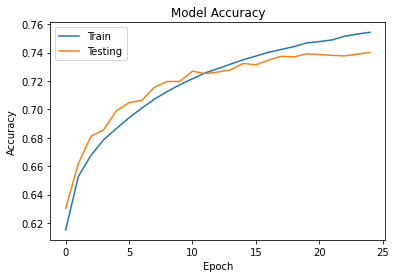

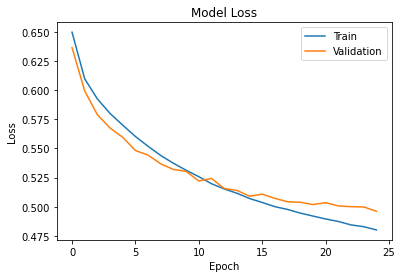

END


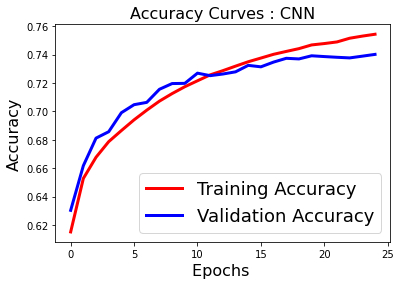

In [35]:
model.load_weights(bst_model_path)
bst_val_score = min(hist.history['val_loss'])
bst_val_acc = max(hist.history['val_acc'])
bst_f1_score = max(hist.history['val_f1_m'])
bst_precision_score = max(hist.history['val_precision_m'])
bst_recall_score = max(hist.history['val_recall_m'])
print("Best Log_loss Value is: ", bst_val_score)
print("Best Val_acc Value is: ", bst_val_acc)
print("Best F1 Score is: ", bst_f1_score)
print("Best Precision is: ", bst_precision_score)
print("Best Recall is: ", bst_recall_score)
########################################
## make the submission
########################################
# print('Start making the submission before fine-tuning')
# print('Making Submission')

# preds = model.predict([test_data_1, test_data_2, test_feat, test_q1_freq, test_q2_freq], batch_size=8192, verbose=1)
# # print("Pred1", preds)
# preds += model.predict([test_data_2, test_data_1, test_feat, test_q1_freq, test_q2_freq], batch_size=8192, verbose=1)
# # print("Pred2", preds)
# preds /= 2
# print("Pred3", preds)

# submission = pd.DataFrame({'test_id':test_ids, 'is_duplicate':preds.ravel()})
# submission.to_csv('%.4f_'%(bst_val_score)+STAMP+'.csv', index=False)


import matplotlib.pyplot as plt
# #
# # Plot accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Testing'], loc='upper left')
plt.show()
#
# Plot loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
print("END")

fig2=plt.figure()
plt.plot(hist.history['acc'],'r',linewidth=3.0)
plt.plot(hist.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()



